<h4>1. Read each frame from the video and save it in a folder 'frames'</h4>

In [1]:
import cv2
import numpy as np
import imutils

video='ind_pak.mp4'

cap = cv2.VideoCapture(video)
cnt=0

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:
    
    #removing scorecard
    roi = frame[:800,:]
    
    #cropping center of an image
    thresh=600
    
    end = roi.shape[1] - thresh
    roi = roi[:,thresh:end]
    
    cv2.imshow("image",roi)

    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

    cv2.imwrite('frames/'+str(cnt)+'.png',roi)
    cnt=cnt+1

  else: 
    break

cv2.destroyAllWindows()  

<h4>Read all frames(images) saved in frames folder in above step. Save it to an array 'images'</h4>

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import re

#listing down all the file names
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

#reading frames
images=[]
for i in frames:
    img = cv2.imread('frames/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(25,25),0)
    images.append(img)

images=np.array(images)

<h4>The main objective is to track the ball on the pitch, we need to extract the frames that contain the pitch.I will use scene detection to accomplish the task. When pitch frame changes to a other frame, difference in two frames will be higher and therefore we will get outlier point in the scatter plot. All frames before the outlier will represent pitch</h4>

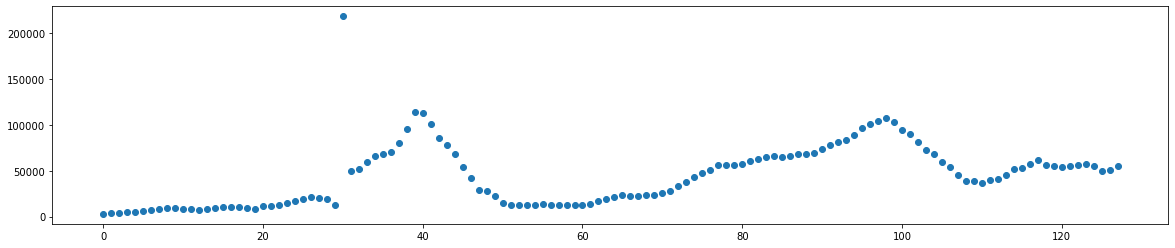

In [3]:
nonzero=[]

for i in range((len(images)-1)):
    mask = cv2.absdiff(images[i],images[i+1]) 
    _ , mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
    num = np.count_nonzero((mask.ravel()))
    nonzero.append(num)
    
x = np.arange(0,len(images)-1)
y = nonzero

plt.figure(figsize=(20,4))
plt.scatter(x,y)

<h4> Extract all pitch frames</h4>

In [4]:
threshold = 15 * 10e3

for i in range(len(images)-1):
    if(nonzero[i]>threshold): 
        scene_change_idx = i
        break
        
frames = frames[:(scene_change_idx+1)]

<h4>Segment pitch images to identify ball. Apply Guassian blur to remove noise and then threshold in such a way that anything below 200 is mapped to 0 and above 200 is mapped to 255. This is done because we already know the color of ball i.e. white</h4>

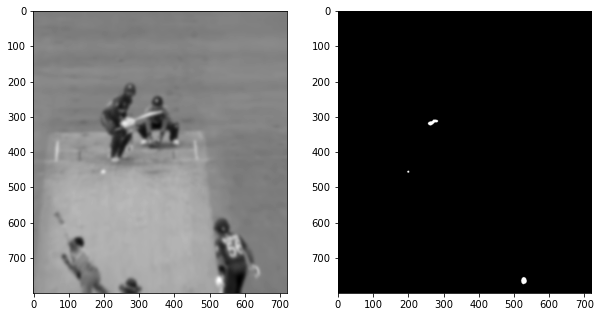

In [5]:
img= cv2.imread('frames/' + frames[10])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(25,25),0)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(gray,cmap='gray')

_ , mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

plt.subplot(122)
plt.imshow(mask,cmap='gray')

<h4>Find the contours of segmented objects in an image.</h4>

In [6]:
contours,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

3

<h4>Image with contours marked</h4>

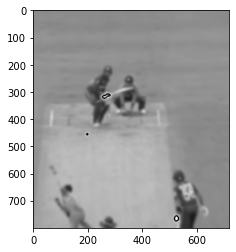

In [7]:
img_copy = np.copy(gray)
cv2.drawContours(img_copy, contours, -1, (0,255,0), 3)
plt.imshow(img_copy, cmap='gray')

<h4>Now that we have knowledge of contours, we can extract those patches from the image, as one of them will contain a ball</h4>

In [8]:
num=20
cnt=0

for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    
    numer=min([w,h])
    denom=max([w,h])
    ratio=numer/denom #we use this ratio to eliminate unusual shape contours

    #if pic is not near edges we take bigger portion of picture
    if(x>=num and y>=num):
        xmin, ymin= x-num, y-num
        xmax, ymax= x+w+num, y+h+num
    else:
        xmin, ymin = x, y
        xmax, ymax = x+w, y+h

    if(ratio>=0.5 and ((w<=10) and (h<=10))):    
        print(x,y,w,h,ratio)
        cv2.imwrite("patch/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])
        cnt=cnt+1

196 453 6 6 1.0


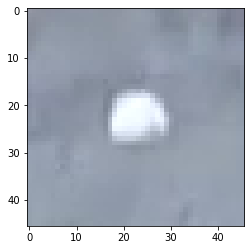

In [9]:
plt.imshow(cv2.imread('patch/0.png'))

<h4>Now we will our pre exisiting dataset to build a classifier. This classifier will have 2 classes, 
    <li>Class 0 : patch images of a ball,
    <li>Class 1 : patch images of other objects (Shoes, Gloves etc.)
</h4>

We will use this model to extract a ball from patches

In [10]:
import os
import cv2
import numpy as np
import pandas as pd

folders=os.listdir('data/')
print(f'folders (classes): {folders}')

images=[]
labels= []

for folder in folders:
    
    files=os.listdir('data/'+folder)
        
    for file in files:
        img=cv2.imread('data/'+folder+'/'+file,0)
        img=cv2.resize(img,(25,25))
        images.append(img)
        labels.append(int(folder))

images = np.array(images)
features = images.reshape(len(images),-1)

folders (classes): ['0', '1']


In [11]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(features,labels, test_size=0.2, stratify=labels,random_state=0)

In [12]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(max_depth=3) 
rfc.fit(x_tr,y_tr)

RandomForestClassifier(max_depth=3)

In [13]:
from sklearn.metrics import classification_report
y_pred = rfc.predict(x_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.83      0.77      0.80        13

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.80      0.79      0.79        24



The above has been done for only one extracted pitch frame. Now we will loop through all images and perform same operation. Also we will create a dataframe which will contain the x,y,w,h co-ordinates of the ball 

In [14]:
ball_df = pd.DataFrame(columns=['frame','x','y','w','h'])
num=20

for idx in range(len(frames)):
    img= cv2.imread('frames/' + frames[idx])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(25, 25),0)
    _ , mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    cnt=0
    
    df = pd.DataFrame(columns=['frame','x','y','w','h'])
    
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])

        numer=min([w,h])
        denom=max([w,h])
        
        ratio=numer/denom

        if(x>=num and y>=num):
            xmin, ymin= x-num, y-num
            xmax, ymax= x+w+num, y+h+num
        else:
            xmin, ymin= x,y
            xmax, ymax= x+w, y+h

        if(ratio>=0.5):    
            df.loc[cnt,'frame'] = frames[idx]
            df.loc[cnt,'x']= x
            df.loc[cnt,'y']= y
            df.loc[cnt,'w']= w
            df.loc[cnt,'h']= h
            
            cv2.imwrite("patch/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])
            cnt=cnt+1
    
    
    files=os.listdir('patch/')    
    if(len(files)>0):
    
        files.sort(key=lambda f: int(re.sub('\D', '', f)))

        test=[]
        for file in files:
            img=cv2.imread('patch/'+file,0)
            img=cv2.resize(img,(25,25))
            test.append(img)

        test = np.array(test)

        test = test.reshape(len(test),-1)
        y_pred = rfc.predict(test)
        prob=rfc.predict_proba(test)

        
        if 0 in y_pred:
            ind = np.where(y_pred==0)[0]
            proba = prob[:,0]
            confidence = proba[ind]
            confidence = [i for i in confidence if i>0.7]
            if(len(confidence)>0):
                maximum = max(confidence)
                ball_file=files[list(proba).index(maximum)]
                img= cv2.imread('patch/'+ball_file)
                cv2.imwrite('ball/'+str(frames[idx]),img)
                no = int(ball_file.split(".")[0])
                ball_df.loc[idx]= df.loc[no]
            else:
                ball_df.loc[idx,'frame']=frames[idx]
        else:
            ball_df.loc[idx,'frame']=frames[idx]

In [15]:
ball_df.dropna(inplace=True)
ball_df.reset_index(drop=True,inplace=True)
print(ball_df)

     frame    x    y   w   h
0    4.png  191  481   8   9
1    5.png  191  469   8   7
2    6.png  192  459   6   6
3    7.png  193  453   6   6
4    8.png  194  450   5   5
5    9.png  195  450   6   5
6   10.png  196  453   6   6
7   11.png  197  459   7   7
8   12.png  199  469   7   7
9   14.png  204  500  11  11
10  15.png  208  520  12  14
11  16.png  216  548  12  14
12  17.png  223  580  14  17
13  18.png  233  616  14  23
14  19.png  240  624  13  21
15  20.png  243  587  10  15


<h4>Make bounding boxes around the ball. Save the frames</h4>

In [16]:
files = ball_df['frame'].values

num=10

for idx in range(len(files)):
    img = cv2.imread('frames/'+files[idx])
    
    x=ball_df.loc[idx,'x']
    y=ball_df.loc[idx,'y']
    w=ball_df.loc[idx,'w']
    h=ball_df.loc[idx,'h']
    
    xmin=x-num
    ymin=y-num
    xmax=x+w+num
    ymax=y+h+num

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.imwrite("frames/"+files[idx],img)  

<h4>Assemble all the frames to make a video</h4>

In [17]:
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('ind_pak_bb.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
    
out.release()